# Death profile used for fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from numba import jit
import sys
import pickle

sys.path.append("../../simulator/")
sys.path.append("../../fitting/")

from tissue import *
import tiss_optimize as topt
import sim_model

%matplotlib inline

def addPBC(points, L, rinc = None): #rinc is inclusion radius for PBCs
    if rinc == None:
        rinc = L
    vx = L*np.array((1,0), dtype = np.float64)
    vy = L*np.array((0,1), dtype = np.float64)
    left  = points[:,0] < rinc
    right = points[:,0] > L - rinc
    up    = points[:,1] > L - rinc
    down  = points[:,1] < rinc
    points = np.vstack([points, 
                        points[left ].copy() + vx, 
                        points[right].copy() - vx, 
                        points[up   ].copy() - vy, 
                        points[down ].copy() + vy, 
                        points[left  & down].copy() + vx + vy, 
                        points[right & up  ].copy() - vx - vy, 
                        points[left  & up  ].copy() + vx - vy, 
                        points[right & down].copy() - vx + vy])
    return points


def load_object(filename):
    with open(filename, 'rb') as outp:  # Overwrites any existing file.
        return pickle.load(outp)
    
from matplotlib import rcParams

# Set global font properties
rcParams['font.family'] = 'sans-serif'

# Set global font size for all axes
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 'bold'
rcParams['xtick.labelsize'] = 7.5
rcParams['ytick.labelsize'] = 7.5
rcParams['legend.fontsize'] = 7.5
rcParams['font.size'] = 7.5  # General font size
rcParams['text.usetex'] = False
rcParams['svg.fonttype'] = 'none'
rcParams['lines.markersize']  = 4
rcParams['lines.linewidth']  = 1.5

In [2]:
exp_data = load_object('../../experiment/ablation.pkl')

av_edu_pc = exp_data['expDivrate']/exp_data['ctrDivrate']
se_edu_pc = exp_data['expSEDivrate']/exp_data['ctrDivrate']
ct_edu_pc = 1.0

av_bas = exp_data['expDensity']
sd_bas = exp_data['expSEDensity']

av_bas_exp = exp_data['expBasalsize']
se_bas_exp = exp_data['expSEBasalsize']

av_tot_exp = exp_data['expTotalsize']
se_tot_exp = exp_data['expSETotalsize']

tdr = exp_data['expTimeDivrate']
tds = exp_data['expTimeDensity']
te  = exp_data['expTimeClonesize']

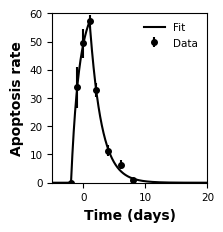

In [3]:
#Death profile:

#Numbers obtained by non-linear least square fits to data
b1 = 3.2553e-2
b2 = 8.7969e-1
bx = 0.5240

def death(t, b1, b2, bx, tscale = 1, tshift = 0, tmin = - 3):
    t = t/tscale + tshift
    if type(t) == int or type(t) == float:
        t = np.array([t])
    y = np.zeros(len(np.array(t)))
    y[t >= 0] = np.exp(-bx*t[t >= 0])
    y[t  < 0] = np.exp(b1*(t[t < 0] - tmin))*(1 - np.exp(-b2*(t[t < 0] - tmin)))/np.exp(-tmin*b1)/(1 - np.exp(tmin*b2))
    y[t < tmin] = 0.0
    return y

x = np.linspace(-5.5, 20, 22*101)

plt.figure(figsize=(2.0,2.2))
plt.errorbar(exp_data['timeCas3'], exp_data['expCas3'], exp_data['expSECas3']*1.96, fmt = 'ko', label = 'Data')
plt.plot(x, death(x - 1, b1, b2, bx)*np.max(exp_data['expCas3']), 'k-', label = 'Fit')
plt.ylabel('Apoptosis rate') 
plt.xlabel('Time (days)')
plt.legend(frameon=False)
plt.xlim([-5,20])
plt.ylim([0,60])
plt.savefig('deathprofile.pdf', dpi = 300, bbox_inches='tight')
plt.show()